In [1]:
from pettingzoo.butterfly import knights_archers_zombies_v10
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
import optuna
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

2024-11-06 22:52:00.758502: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 22:52:01.000678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 22:52:01.098590: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 22:52:01.124219: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 22:52:01.304590: I tensorflow/core/platform/cpu_feature_guar

## L'environnement

In [2]:
class PettingZooEnvWrapper(gym.Env):
    def __init__(self, env):
        super(PettingZooEnvWrapper, self).__init__()
        self.env = env
        self.env.reset()
        self.action_space = gym.spaces.Discrete(self.env.action_space(self.env.agents[0]).n)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=self.env.observation_space(self.env.agents[0]).shape, dtype=np.float32)
        self.current_agent = self.env.agents[0]
        self.agents=self.env.agents
    def reset(self,seed=None, **kwargs):
        self.env.reset(seed=seed)
        self.current_agent = self.env.agents[0]
        obs, _, _, _,infos = self.env.last()
        return obs,infos
    def step(self, action):
        y_tolerance = 0.98
        collision_threshold = 0.02
        self.env.step(action)
        num_zombies = self.env.env.max_zombies
        obs, reward,terminated,truncated, info = self.env.last()
        self.current_agent = self.env.agent_selection
        #-------------------------------------------------------
        # Extract zombie positions and detect collisions for penalties
        zombies = obs[-num_zombies:]  # Extract the last rows representing zombies
        total_zombies_reached_border = 0
        total_collisions = 0

        for zombie in zombies:
            distance_to_current_agent = zombie[0]  # Distance to the agent
            y_position = zombie[1]  # Y-position of the zombie
            x_position = zombie[2] # X-position of the zombie
        
            # Check if the zombie reached the border (y=1)
            if y_position >= y_tolerance and x_position != 0 and distance_to_current_agent != 0:
                #y_position = 0, x_position = 0, distance_to_current_agent = 0 means the zombie is not spawn or dead
                total_zombies_reached_border += 1  # Track zombies that reached the border

            # Check if the agent collided with the zombie (close distance)
            if distance_to_current_agent <= collision_threshold and x_position != 0 and y_position >= 0:
                #y_position = 0, x_position = 0, distance_to_current_agent = 0 means the zombie is not spawn or dead
                total_collisions += 1

        # Modify the real-time reward during training based on penalties
        if total_zombies_reached_border > 0:
            reward -= 1  # Penalize the agent for letting zombies reach the border

        if total_collisions > 0:
            reward -= 1  # Penalize the agent for colliding with a zombie
        #-------------------------------------------------------
        return obs, reward, terminated,truncated, info
    
    def render(self):
        return self.env.render()   


In [3]:
#env = knights_archers_zombies_v10.env(render_mode="human",max_zombies=4,max_cycles=100)
env = knights_archers_zombies_v10.env(render_mode="rgb_array",max_zombies=4,max_cycles=100)

wrapped_env = PettingZooEnvWrapper(env)

## Boucle d'apprentisage

In [4]:
def train(env, agents, num_episodes=100,affichage=True):
    for episode in range(num_episodes):
        env.reset()
        terminated = False
        truncated=False
        #print(episode)
        for agent in env.agents:
            if terminated or truncated:
                print(not (terminated or truncated))
            current_agent = env.current_agent
                
            obs, _, terminated,truncated, _ = env.env.last()
            if terminated or truncated:
                break
                
            action, _states = agents[agent].predict(obs, deterministic=True)
            #print(action)
            env.step(action)
                
            next_obs, reward, terminated,truncated, _ = env.env.last()
                
            # Collect experience and train the agent
            agents[agent].learn(total_timesteps=1000)

                
        # Optionally evaluate performance
        # if episode % 10 == 0 and affichage:
        for agent in agents:
            mean_reward, _ = evaluate_policy(agents[agent], wrapped_env, n_eval_episodes=10)
            print(f"Agent {agent}: Mean reward: {mean_reward}")

    env.env.close()

## Optuna optimisation

In [8]:
def sample_dqn_params(trial: optuna.Trial) :
    """
    Sampler for DQN hyperparams.

    :param trial:
    :return:
    """
    gamma = trial.suggest_categorical("gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 100, 128, 256, 512])
    buffer_size = trial.suggest_categorical("buffer_size", [int(1e4), int(5e4), int(1e5), int(1e6)])
    exploration_final_eps = trial.suggest_float("exploration_final_eps", 0, 0.2)
    exploration_fraction = trial.suggest_float("exploration_fraction", 0, 0.5)
    target_update_interval = trial.suggest_categorical("target_update_interval", [1, 1000, 5000, 10000, 15000, 20000])
    learning_starts = trial.suggest_categorical("learning_starts", [0, 1000, 5000, 10000, 20000])

    train_freq = trial.suggest_categorical("train_freq", [1, 4, 8, 16, 128, 256, 1000])
    subsample_steps = trial.suggest_categorical("subsample_steps", [1, 2, 4, 8])
    gradient_steps = max(train_freq // subsample_steps, 1)

    net_arch_type = trial.suggest_categorical("net_arch", ["tiny", "small", "medium"])

    net_arch = {"tiny": [64], "small": [64, 64], "medium": [256, 256]}[net_arch_type]

    hyperparams = {
        "gamma": gamma,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "buffer_size": buffer_size,
        "train_freq": train_freq,
        "gradient_steps": gradient_steps,
        "exploration_fraction": exploration_fraction,
        "exploration_final_eps": exploration_final_eps,
        "target_update_interval": target_update_interval,
        "learning_starts": learning_starts,
        "policy_kwargs": dict(net_arch=net_arch),
    }

    env = knights_archers_zombies_v10.env(render_mode="rgb_array",max_zombies=4,max_cycles=100)

    wrapped_env = PettingZooEnvWrapper(env)
    agents = {agent: DQN("MlpPolicy", wrapped_env, verbose=0,**hyperparams) for agent in env.agents}

    train(wrapped_env,agents,num_episodes=10,affichage=False)
    total_reward=0
    for agent in agents:
            mean_reward, _ = evaluate_policy(agents[agent], wrapped_env, n_eval_episodes=10)
            total_reward+=mean_reward


    return -total_reward

In [ ]:
study_dqn=optuna.study.create_study()
study_dqn.optimize(sample_dqn_params, n_trials=10)


In [6]:
best_hyperparams={'gamma': 0.95,
 'learning_rate': 0.0057832857004646385,
 'batch_size': 512,
 'buffer_size': 1000000,
 'exploration_final_eps': 0.038076390363142434,
 'exploration_fraction': 0.1311871993781526,
 'target_update_interval': 15000,
 'learning_starts': 1000,
 'train_freq': 256,
 "policy_kwargs": dict(net_arch=[64])}
agents = {agent: DQN("MlpPolicy", wrapped_env, verbose=0,**best_hyperparams) for agent in env.agents}
#best_hyperparams

In [7]:
train(wrapped_env, agents, 5) #10 pas d'apprentissage

/home/tibi/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Agent archer_0: Mean reward: -0.1
Agent archer_1: Mean reward: -0.8
Agent knight_0: Mean reward: -0.3
Agent knight_1: Mean reward: -0.6
Agent archer_0: Mean reward: -0.1
Agent archer_1: Mean reward: 0.0
Agent knight_0: Mean reward: 0.0
Agent knight_1: Mean reward: -0.9
Agent archer_0: Mean reward: 1.3
Agent archer_1: Mean reward: 0.0
Agent knight_0: Mean reward: 0.0
Agent knight_1: Mean reward: -0.6
Agent archer_0: Mean reward: 0.2
Agent archer_1: Mean reward: 0.0
Agent knight_0: Mean reward: -0.1
Agent knight_1: Mean reward: -0.8
Agent archer_0: Mean reward: 0.9
Agent archer_1: Mean reward: 0.0
Agent knight_0: Mean reward: -0.1
Agent knight_1: Mean reward: 0.3


## Affichage de l'environnement

In [5]:
import os
import imageio

# Configurer le répertoire pour enregistrer la vidéo
video_directory = "./vids_newstep"
os.makedirs(video_directory, exist_ok=True)
video_path = os.path.join(video_directory, "trained_agents.mp4")

In [6]:
def render_trained_agents_with_custom_video(env, agents, max_steps_per_episode=100):
    obs, _ = env.reset()  # Reset environment
    step_count = 0  # Initialize step counter
    frames = []  # Liste pour stocker les frames de l'épisode

    while step_count < max_steps_per_episode:
        current_agent = env.current_agent

        # Get current observation
        obs, _, _, _, _ = env.env.last()

        # Get action from the trained agent's policy
        action, _states = agents[current_agent].predict(obs, deterministic=True)

        # Step through the environment
        next_obs, reward, terminated, truncated, _ = env.step(action)

        # Render the environment and append the frame to frames list
        frame = env.render()
        frames.append(frame)  # Ajouter la frame pour la vidéo

        # Increment the step counter
        step_count += 1

        # Terminate if the episode is done
        if terminated or truncated:
            break

    env.env.close()  # Close the environment

    # Enregistrer la vidéo avec imageio
    imageio.mimsave(video_path, frames, fps=30)
    print(f"Video saved in: {video_path}")

In [11]:
# human_env = knights_archers_zombies_v10.env(render_mode="rgb_array", max_zombies=4, max_cycles=1000)

# human_wrapped_env = PettingZooEnvWrapper(human_env)

render_trained_agents_with_custom_video(wrapped_env, agents, max_steps_per_episode=1000)

Video saved in: ./vids_newstep/trained_agents.mp4


In [3]:
def render_trained_agents(env, agents, max_steps_per_episode=100):
    obs, _ = env.reset()  # Reset environment
    step_count = 0  # Initialize step counter

    while step_count < max_steps_per_episode:
        current_agent = env.current_agent

        # Get current observation
        obs, _, _, _, _ = env.env.last()

        # Get action from the trained agent's policy
        action, _states = agents[current_agent].predict(obs, deterministic=True)

        # Step through the environment
        next_obs, reward, _, _, _ = env.step(action)

        # Render the environment
        env.render()

        # Increment the step counter
        step_count += 1

    env.env.close()  # Close the environment

In [16]:
human_env = knights_archers_zombies_v10.env(render_mode="human",max_zombies=4,max_cycles=100)

human_wrapped_env = PettingZooEnvWrapper(human_env)
render_trained_agents(human_wrapped_env, agents, max_steps_per_episode=100)

## Plot de performance

In [7]:
def train_with_logging(env, agents, num_episodes=10000):
    agent_rewards = {agent: [] for agent in env.agents}  # Store cumulative rewards for each agent
    mean_rewards = []  # Store mean rewards across agents

    for episode in range(num_episodes):
        env.reset()
        terminated = False
        truncated = False
        cumulative_rewards = {agent: 0 for agent in env.agents}  # Cumulative rewards per episode
        
        print(f"Episode: {episode}")

        for agent in env.agents:
            if terminated or truncated:
                print(not (terminated or truncated))
            current_agent = env.current_agent
                
            obs, _, terminated, truncated, _ = env.env.last()
            if terminated or truncated:
                break
                
            action, _states = agents[agent].predict(obs, deterministic=True)
            env.step(action)
                
            next_obs, reward, terminated, truncated, _ = env.env.last()
                
            agents[agent].learn(total_timesteps=1000)


        # Optionally evaluate performance
        #if episode % 10 == 0:
        for agent in agents:
            mean_reward, _ = evaluate_policy(agents[agent], wrapped_env, n_eval_episodes=10)
            agent_rewards[agent].append(mean_reward)  # Record cumulative reward for each agent

            print(f"Agent {agent}: Mean reward: {mean_reward}")

        mean_rewards.append(np.mean([agent_rewards[agent] for agent in env.agents]))  # Record mean reward across agents

    env.env.close()

    return agent_rewards, mean_rewards

In [8]:
import matplotlib.pyplot as plt

# Function to plot the learning curves for each agent and the mean reward
def plot_learning_curves(agent_rewards, mean_rewards):
    plt.figure(figsize=(14, 8))

    # Plot the learning curve for each agent
    plt.subplot(2, 1, 1)
    for agent, rewards in agent_rewards.items():
        plt.plot(rewards, label=f'Agent {agent}')
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Reward')
    plt.title('Learning Curves for Each Agent')
    plt.legend()

    # Plot the mean reward curve
    plt.subplot(2, 1, 2)
    plt.plot(mean_rewards, label='Mean Reward', color='black', linewidth=2)
    plt.xlabel('Episodes')
    plt.ylabel('Mean Reward')
    plt.title('Mean Reward Across All Agents')

    plt.tight_layout()
    plt.show()

Episode: 0


/home/tibi/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Agent archer_0: Mean reward: 0.4
Agent archer_1: Mean reward: -0.3
Agent knight_0: Mean reward: 0.4
Agent knight_1: Mean reward: 0.4
Episode: 1
Agent archer_0: Mean reward: 0.8
Agent archer_1: Mean reward: -0.4
Agent knight_0: Mean reward: 0.2
Agent knight_1: Mean reward: 0.8
Episode: 2
Agent archer_0: Mean reward: 0.3
Agent archer_1: Mean reward: -0.9
Agent knight_0: Mean reward: 0.5
Agent knight_1: Mean reward: 0.8
Episode: 3
Agent archer_0: Mean reward: 0.8
Agent archer_1: Mean reward: 0.0
Agent knight_0: Mean reward: 0.8
Agent knight_1: Mean reward: 0.8
Episode: 4
Agent archer_0: Mean reward: 0.5
Agent archer_1: Mean reward: 0.2
Agent knight_0: Mean reward: 0.0
Agent knight_1: Mean reward: 1.2
Episode: 5
Agent archer_0: Mean reward: 0.4
Agent archer_1: Mean reward: -0.4
Agent knight_0: Mean reward: 0.4
Agent knight_1: Mean reward: 0.6
Episode: 6
Agent archer_0: Mean reward: -0.9
Agent archer_1: Mean reward: -0.3
Agent knight_0: Mean reward: 0.5
Agent knight_1: Mean reward: 1.3
Epis

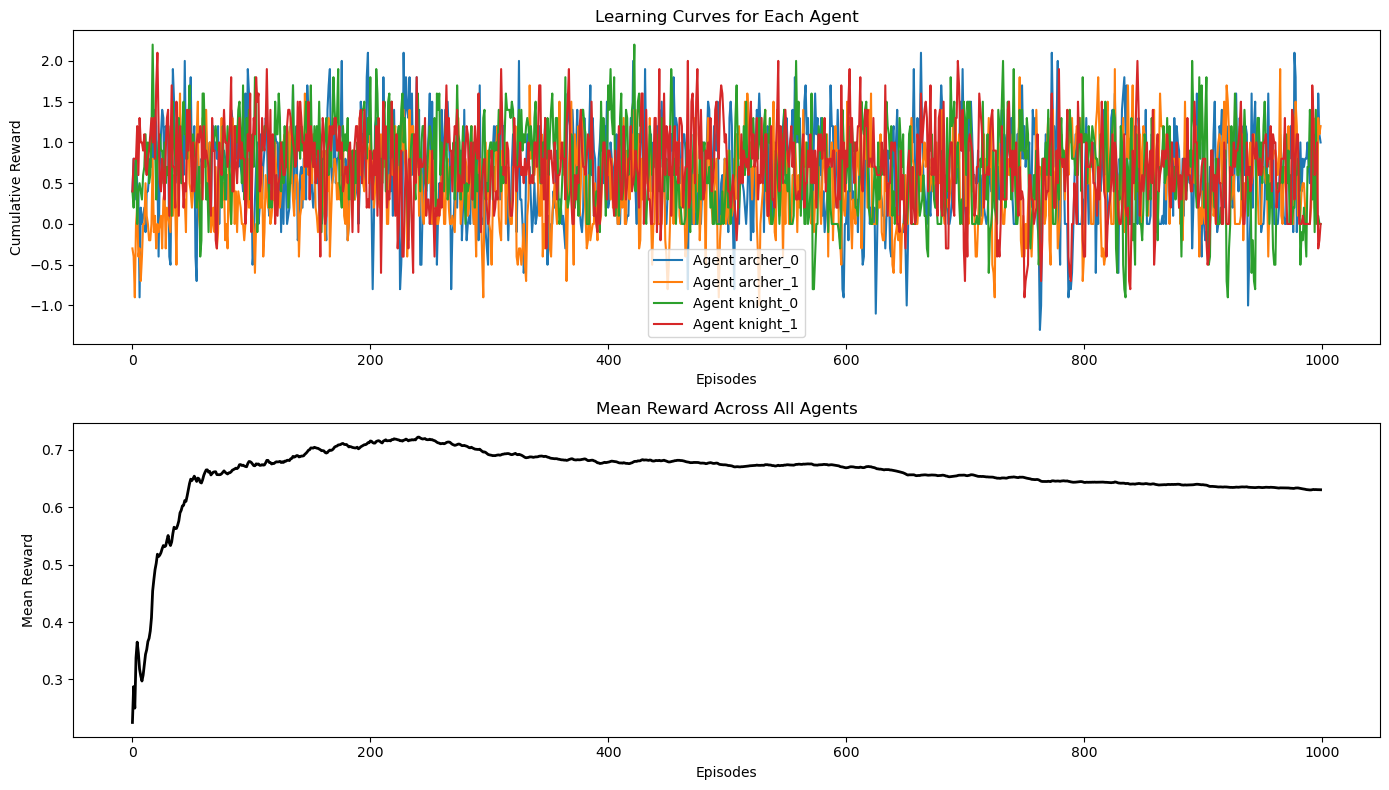

In [9]:
env = knights_archers_zombies_v10.env(render_mode="rgb_array",max_zombies=4,max_cycles=100)
wrapped_env = PettingZooEnvWrapper(env)

# hyperparams={'gamma': 0.99,
#  'learning_rate': 0.0001774658772353578,
#  'batch_size': 32,
#  'buffer_size': 10000,
#  'exploration_final_eps': 0.08646173611211427,
#  'exploration_fraction': 0.32951412388518647,
#  'target_update_interval': 1000,
#  'learning_starts': 0,
#  'train_freq': 128,
#  "policy_kwargs": dict(net_arch=[64])}

hyperparams={'gamma': 0.95,
 'learning_rate': 0.0005001046217977603,
 'batch_size': 16,
 'buffer_size': 100000,
 'exploration_final_eps': 0.09536343411663083,
 'exploration_fraction': 0.1821964330021213,
 'target_update_interval': 1,
 'learning_starts': 0,
 'train_freq': 128,
 "policy_kwargs": dict(net_arch=[64])}

agents = {agent: DQN("MlpPolicy", wrapped_env, verbose=0,**hyperparams) for agent in env.agents}
#agents = {agent: DQN("MlpPolicy", wrapped_env, verbose=0) for agent in env.agents}
agent_rewards, mean_rewards = train_with_logging(wrapped_env, agents, num_episodes=1000)

# Plot the learning curves
plot_learning_curves(agent_rewards, mean_rewards)

In [10]:
video_directory = "./vids_newstep"
os.makedirs(video_directory, exist_ok=True)
video_path = os.path.join(video_directory, "trained_agents_1000_episodes_newstep.mp4")

In [12]:
# human_env = knights_archers_zombies_v10.env(render_mode="rgb_array", max_zombies=4, max_cycles=1000)

# human_wrapped_env = PettingZooEnvWrapper(human_env)

render_trained_agents_with_custom_video(wrapped_env, agents, max_steps_per_episode=1000)

Video saved in: ./vids_newstep/trained_agents_1000_episodes_newstep.mp4
